## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Read datasets

In [2]:
# Read datasets into Pandas DataFrames

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Split dataset into train (80%), dev (10%), test(10%) sets

In [3]:
def train_dev_test_split(dataset):
    '''
    Splits dataset into train(80%), developement(10%) and test sets(10%).
    
    Argument:
    dataset -- Pandas DataFrame
    
    Returns:
    train_X, train_Y -- training set and respective labels
    dev_X, dev_Y -- developement set and respective labels
    test_X, test_Y -- test set and respective labels
    '''
    
    np.random.seed(2)
    shuffled_idx = np.random.permutation(dataset.shape[0])
    
    dataset = dataset.iloc[shuffled_idx]

    split_1 = int(0.8 * dataset.shape[0])
    split_2 = int(0.9 * dataset.shape[0])
    
    train = dataset.iloc[:split_1]
    dev = dataset.iloc[split_1:split_2]
    test = dataset.iloc[split_2:]
    
    X = dataset.iloc[:, 1:].values.astype('float32')
    Y = dataset.iloc[:, 0].values.astype('int32')
    
    train_X, train_Y = train.iloc[:, 1:].values.astype('float32'), train.iloc[:, 0].values.astype('int32')
    dev_X, dev_Y = dev.iloc[:, 1:].values.astype('float32'), dev.iloc[:, 0].values.astype('int32')
    test_X, test_Y = test.iloc[:, 1:].values.astype('float32'), test.iloc[:, 0].values.astype('int32')
    
    return train_X, train_Y, dev_X, dev_Y, test_X, test_Y

In [4]:
# Split dataset

train_X, train_Y, dev_X, dev_Y, test_X, test_Y = train_dev_test_split(train)

holdout = holdout.values.astype('float32')

# Standardize the datasets

for dataset in [train_X, dev_X, test_X]:   
    dataset = dataset / 255

Training example label: 6


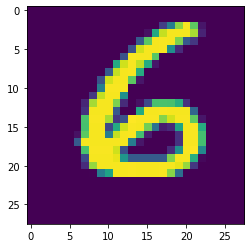

In [5]:
# Vizualize training example

num_px = np.sqrt(train_X.shape[1]).astype('int32')
plt.imshow(train_X[0].reshape(num_px, num_px))

print("Training example label:", train_Y[0])

## Create useful functions

In [6]:
def convert_to_one_hot(Y, C):
    '''
    Converts vector to an array of one hot vectors
    
    Arguments: 
    Y -- input vector of shape (number of examples,) 
    C -- number of classes, integer
    
    Returns:
    one_hot -- array of one hot vectors, of shape (number of examples, C)
    '''
    one_hot = np.eye(C)[Y.reshape(-1)]
    return one_hot


def relu(z):
    '''
    Computes the relu function of z
    
    Arguments:
    z -- Scalar or array of any size
    
    Returns:
    a -- maximum of (z, 0)
    cache -- storage for z; useful for backpropagation
    '''
    
    a = np.maximum(z, 0)
    cache = z
    
    return a, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def softmax(z, axis=1):
    '''
    Computes the softmax function of z
    
    Arguments:
    z -- Array of any size
    
    Returns:
    s -- softmax of z
    cache -- storage for z; useful for backpropagation
    '''
    
    e_x = np.exp(z)
    sum_e_x = np.sum(e_x, axis)
    sum_e_x = sum_e_x[:, np.newaxis]  # adding axis to the array. necessary step to do broadcasting
    
    s = e_x / sum_e_x
    cache = z
    
    return s, cache

In [7]:
# Ensure the softmax function is working correcty 
sft_test = np.array([5,2,-1,3]).reshape(1,4)

softmax(sft_test)

(array([[0.84203357, 0.04192238, 0.00208719, 0.11395685]]),
 array([[ 5,  2, -1,  3]]))

## Initialize parameters

In [8]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l-1])
    """
    
    np.random.seed(1)
    
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l]) * 0.01
        parameters['b' + str(l)] = np.zeros((1, layer_dims[l]))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l-1], layer_dims[l]))
        assert(parameters['b' + str(l)].shape == (1, layer_dims[l]))
    
    return parameters

In [9]:
parameters = initialize_parameters(layer_dims=[784, 4, 5, 10])

print('Parameters shape', '\n')
for param in parameters.keys():
    print(param + ': ' + str(parameters[param].shape))

Parameters shape 

W1: (784, 4)
b1: (1, 4)
W2: (4, 5)
b2: (1, 5)
W3: (5, 10)
b3: (1, 10)


## Forward propagation

In [10]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (number of examples, size of previous layer)
    W -- weights matrix: numpy array of shape (size of previous layer, size of current layer)
    b -- bias vector, numpy array of shape (1, size of the current layer)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(A, W) + b
    
    assert(Z.shape == (A.shape[0], W.shape[1]))
    cache = (A, W, b)
    
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A -- activations from previous layer (or input data): (number of examples, size of previous layer)
    W -- weights matrix: numpy array of shape (size of previous layer, size of current layer)
    b -- bias vector, numpy array of shape (1, size of the current layer)

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    elif activation == 'softmax':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    
    assert(A.shape == (A_prev.shape[0], W.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [11]:
# Forward propagation

def L_model_forward(X, parameters):
    '''
    Implement forward propagation of the neural network.
    
    Arguments:
    X - input array of shape (number of examples, 784)
    parameters -- python dictionary containing model parameters 
    
    Returns:
    AL -- the output of the last layer's activation function
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    '''
    caches = []
    A = X
    L = len(parameters) // 2
    
    # first (L-1) layers
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation='relu')
        caches.append(cache)
        
    # Last layer
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation='softmax')
    caches.append(cache)
    
    assert(AL.shape == (X.shape[0], 10))
    
    return AL, caches

## Compute Cost

In [12]:
def compute_cost(AL, Y):
    """
    Compute the cost
    
    Arguments:
    A3 -- softmax activation output of L_model_forward(), of shape (number of examples, 10)
    Y -- "true" labels array, of shape (number of examples, 1)
    
    Returns:
    cost -- cross-entropy cost
    """
    
    m = AL.shape[0] # number of examples
    
    # converting Y into a matrix of one hot vectors of shape (number of examples, 10)
    Y_one_hot = convert_to_one_hot(Y, 10)
    
    loss = -np.sum(np.multiply(Y_one_hot, np.log(AL)), axis=1)
    
    assert (loss.shape == (m,))
    
    cost = (1/m) * np.sum(loss)
    
    return cost  

## Back-propagation

In [13]:
def linear_backward(dZ, cache):
    '''
    Implement linear backward propagation for layer l.
    
    Arguments:
    dZ -- gradient of cost function with respect to the linear output (of current layer l)
    cache -- tuple (A_prev, W, b) output from L_model_forward()
    
    Returns:
    dA_prev - gradient of cost function with respect to previous activation layer (A_prev)
    dW - gradient of cost function with respect to W
    db - gradient of cost function with respect to b 
    '''
    A_prev, W, b = cache
    m = A_prev.shape[0]
    
    dW = 1/m * np.dot(A_prev.T, dZ)
    db = 1/m * np.sum(dZ, axis=0, keepdims=True)
    dA_prev = np.dot(dZ, W.T)
    
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    assert (dA_prev.shape == A_prev.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache):
    '''
    Implement back propagation for the Linear -> Activation layer.
    
    Arguments:
    dA -- post activation gradient for layer l
    cache -- tuple of values (linear_cache, activation_cache) for computing back propagation efficiently
    
    Returns:
    dA_prev - gradient of cost function with respect to previous activation layer (l-1)
    dW - gradient of cost function with respect to W (current layer l)
    db - gradient of cost function with respect to b (current layer l)
    
    '''
    linear_cache, activation_cache = cache
    
    dZ = relu_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [14]:
def L_model_backward(AL, Y, caches):
    '''
    Implement backward propagation on whole network
    
    Arguments:
    AL - probability vector, output of forward propagation
    Y - true label vector
    caches - list of every cache of L_model_forward() 
    
    Returns:
    grads - dictionary with gradients i.e. grads["dA" + str(l)] = ... 
    '''
    
    grads = {}
    L = len(caches)         # number of layers
    m = AL.shape[0]         # number of examples
    
    Y_one_hot = convert_to_one_hot(Y, 10)
    
    # Initializing the backpropagation
    
    dZL = AL - Y_one_hot
    current_cache = caches[L-1]
    
    grads['dA' + str(L-1)], grads['dW' + str(L)] , grads['db' + str(L)] = linear_backward(dZL, current_cache[0])
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        grads['dA' + str(l)], grads['dW' + str(l+1)] , grads['db' + str(l+1)] = linear_activation_backward(grads['dA' + str(l+1)], current_cache)
        
    return grads

## Update parameters

In [15]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing model parameters 
    grads -- python dictionary containing model gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    ### END CODE HERE ###
    return parameters

In [16]:
# Batch gradient descent

def NN_model(X, Y, layer_dims, num_iterations, learning_rate, print_cost=False):
    '''
    Implement a L-layer neural network: LINEAR->RELU->...->LINEAR->SOFTMAX.
    
    Arguments:
    X -- input data, of shape (number examples, num_px)
    Y -- true label vector, of shape (number examples, 1)
    layer_dims -- list containing input size and each layer size, of lenght (no. layers + 1)
    num_iterations -- number of iterations of the optimization step
    learning_rate -- for gradient descent
    print_cost -- if True, prints cost every 20 iterations
    
    Returns:
    parameters -- parameters learnt by NN model, useful for predictions
    '''
    
    parameters = initialize_parameters(layer_dims)
    
    for i in range(0, num_iterations):
        # Forward propagation
        AL, caches = L_model_forward(X, parameters)
        
        # Cost function
        cost = compute_cost(AL, Y)
        
        # Back propagation. Computing the parameters' gradients with repect to the cost functions
        grads = L_model_backward(AL, Y, caches)
        
        # Updating parameters using gradient descent
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 20 == 0:
            print('cost after iteration {}: {}'.format(i, cost))
        
    return parameters

In [17]:
# Mini-batch gradient descent

def init_mini_batches(X, Y, mini_batch_size, seed = 0):
    '''
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, input size)
    Y -- true label vector of shape (number of examples, 1)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of mini-batches (mini_batch_X, mini_batch_Y)
    '''
    
    np.random.seed(seed)
    m = X.shape[0]
    
    #Shuffle X and Y
    permuts = np.random.permutation(m)
    X_random = X[permuts, :]
    Y_random = Y[permuts]
    
    # Creating the minibatches
    mini_batches = []
    complete_minibatches = np.floor(m / mini_batch_size).astype('int')
    
    # When mini_batch == mini_batch_size
    for k in range(complete_minibatches):
        mini_batch_X = X_random[(mini_batch_size*k):(mini_batch_size*(k+1)), :]
        mini_batch_Y = Y_random[(mini_batch_size*k):(mini_batch_size*(k+1))]
        
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    # When last mini_batch < mini_batch_size
    if m % mini_batch_size != 0:
        mini_batch_X = X_random[(mini_batch_size * complete_minibatches):, :]
        mini_batch_Y = Y_random[(mini_batch_size * complete_minibatches):]
        
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    return mini_batches

In [18]:
# Gradient descent with momentum 

def initialize_momentum(parameters):
    '''
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    '''
    
    L = len(parameters) // 2 # number of layers
    v = {}    # storage for velocity
    
    # Initialize velocity
    for l in range(L):
        v['dW' + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v['db' + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
    
    return v


def update_params_momentum(parameters, grads, v, beta, learning_rate):
    '''
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    '''
    
    L = len(parameters) // 2 # number of layers

    # Momentum update
    for l in range(L):
        # Updating W[l+1] using velocity
        v['dW' + str(l+1)] = (beta * v['dW' + str(l+1)]) + (1-beta) * grads['dW' + str(l+1)]
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * v['dW' + str(l+1)]
        
        # Updating b[l+1] using velocity
        v['db' + str(l+1)] = (beta * v['db' + str(l+1)]) + (1-beta) * grads['db' + str(l+1)]
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * v['db' + str(l+1)]
        
    return parameters, v


In [19]:
def initialize_adam(parameters):
    '''
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    '''
    
    L = len(parameters) // 2 # number of layers
    v = {}   # exponentially weighted average of the gradient
    s = {}   # exponentially weighted average of the squared gradient
    
    # initialize v and s as array of zeros
    for l in range(L):
        v['dW' + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v['db' + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)       
        s['dW' + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s['db' + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
    
    return v, s


def update_params_adam(parameters, grads, learning_rate, v, s, t, beta_1, beta_2, epsilon):
    '''
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- number of steps taken of Adam 
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    '''
    
    L = len(parameters) // 2 # number of layers
    v_corrected = {}
    s_corrected = {}
    
    # update parameters using Adam algorithm

    for l in range(L):
        # moving average of gradients
        v['dW' + str(l+1)] = (beta_1 * v['dW' + str(l+1)]) + (1-beta_1) * grads['dW' + str(l+1)]
        v['db' + str(l+1)] = (beta_1 * v['db' + str(l+1)]) + (1-beta_1) * grads['db' + str(l+1)]
        
        # moving average of gradients with bias correction
        v_corrected['dW' + str(l+1)] = v['dW' + str(l+1)] / (1 - np.power(beta_1, t))
        v_corrected['db' + str(l+1)] = v['db' + str(l+1)] / (1 - np.power(beta_1, t))
        
        # moving average of squared gradients
        s['dW' + str(l+1)] = (beta_2 * s['dW' + str(l+1)]) + (1-beta_2) * np.power(grads['dW' + str(l+1)], 2)
        s['db' + str(l+1)] = (beta_2 * s['db' + str(l+1)]) + (1-beta_2) * np.power(grads['db' + str(l+1)], 2)
        
        # moving average of squared gradients with bias correction
        s_corrected['dW' + str(l+1)] = s['dW' + str(l+1)] / (1 - np.power(beta_2, t))
        s_corrected['db' + str(l+1)] = s['db' + str(l+1)] / (1 - np.power(beta_2, t))
        
        # update parameters W, b
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * (v_corrected['dW' + str(l+1)] / (np.sqrt(s_corrected['dW' + str(l+1)]) + epsilon))
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * (v_corrected['db' + str(l+1)] / (np.sqrt(s_corrected['db' + str(l+1)]) + epsilon))
        
    return parameters, v, s

In [20]:
def NN_model_optimizer(X, Y, layer_dims, optimizer, mini_batch_size, num_epochs, beta, 
                       beta_1, beta_2, epsilon, learning_rate, seed, print_cost=False):
    '''
    L-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (number of examples, num_px)
    Y -- true "label" vector, of shape (number of examples, 1)
    optimizer -- one of the following: (gradient descent, momentum, adam)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 20 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    '''
    
    m = X.shape[0] # training examples
    # initialize parameters
    parameters = initialize_parameters(layer_dims)
    
    # initialize optimizer
    if optimizer == 'gd':
        pass
    elif optimizer == 'momentum':
        v = initialize_momentum(parameters)
    elif optimizer == 'adam':
        v, s = initialize_adam(parameters)
    
    costs = []
    t = 0 # Initialize Adam counter
    
    # Running gradient descent over num_epochs    
    for i in range(num_epochs):
        # initialize mini_batches
        seed += 1
        mini_batches = init_mini_batches(X, Y, mini_batch_size, seed) 
        
        total_cost = 0
        
        for minibatch in mini_batches:
            # Select minibatches
            (minibatch_X, minibatch_Y) = minibatch
            
            # Forward propagation
            AL, caches = L_model_forward(minibatch_X, parameters)

            # Cost function
            total_cost += (compute_cost(AL, minibatch_Y) * AL.shape[0])

            # Back propagation. Computing the parameters' gradients with repect to the cost functions
            grads = L_model_backward(AL, minibatch_Y, caches)

            # Updating parameters using gradient descent
            if optimizer == 'gd':
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == 'momentum':
                parameters, v = update_params_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == 'adam':
                t += 1 # Increment Adam counter
                parameters, v, s = update_params_adam(parameters, grads, learning_rate, v, s, t, beta_1, beta_2, epsilon=1e-8)
            
        avg_cost = total_cost / m
        
        if print_cost and i % 20 == 0:
            print('Cost epoch {}: {}'.format(i, avg_cost))
        if print_cost:
            costs.append(avg_cost)
            
    # Plot average cost over epochs
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('epochs')
    plt.xlim(0, num_epochs)
    plt.title('Learning rate: ' + str(learning_rate))
    plt.show()
    
    return parameters

Cost epoch 0: 2.2363507900402175
Cost epoch 20: 0.32425387683028223
Cost epoch 40: 0.2958645575081781
Cost epoch 60: 0.2803725071654392
Cost epoch 80: 0.2725421303580354
Cost epoch 100: 0.27052265275926574
Cost epoch 120: 0.26064499762247123
Cost epoch 140: 0.26727747236477384
Cost epoch 160: 0.2563432532668869
Cost epoch 180: 0.26587293928006506


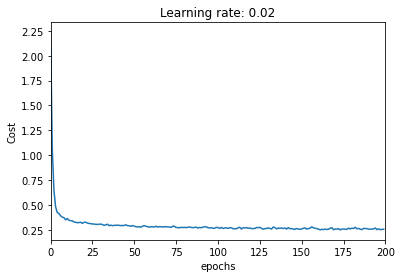

In [21]:
# Train model using momentum optimizer
updated_params_momentum = NN_model_optimizer(train_X, train_Y, layer_dims=[784, 6, 6, 10], optimizer='momentum', 
                    mini_batch_size=512, num_epochs=200, beta=0.9, beta_1=0.9, beta_2=0.999, 
                    epsilon=1e-8, learning_rate=0.02, seed=0, print_cost=True)


Cost epoch 0: 1.4665615127550142
Cost epoch 20: 0.07492682988281078
Cost epoch 40: 0.023248489189304843
Cost epoch 60: 0.0060039977148940125
Cost epoch 80: 0.001690950251372099
Cost epoch 100: 0.0006000874810951491
Cost epoch 120: 0.00024142360370219926
Cost epoch 140: 0.00010101515819088202
Cost epoch 160: 4.4534338847210894e-05
Cost epoch 180: 2.0715114815383486e-05


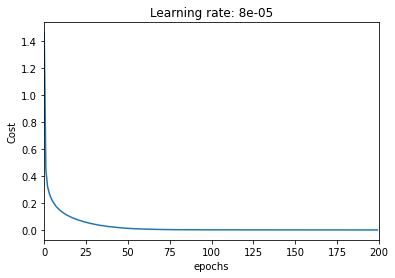

In [22]:
# Train model using Adam optimizer
updated_params_adam = NN_model_optimizer(train_X, train_Y, layer_dims=[784, 100, 100, 10], optimizer='adam', 
                    mini_batch_size=512, num_epochs=200, beta=0.9, beta_1=0.9, beta_2=0.999, 
                    epsilon=1e-8, learning_rate=0.00008, seed=0, print_cost=True)

In [30]:
# Train model using batch gradient descent
params_updated = NN_model(train_X, train_Y, [784, 100, 100, 10], 1000, learning_rate = 0.01, print_cost=True)
params_updated

cost after iteration 0: 2.3204651522919497
cost after iteration 20: 1.4744491125031745
cost after iteration 40: 2.215061175833085
cost after iteration 60: 0.6919147691711135
cost after iteration 80: 0.3720365221335927
cost after iteration 100: 0.3064172644432635
cost after iteration 120: 0.27632436173106373
cost after iteration 140: 0.2998564277310388
cost after iteration 160: 0.23184311188152412
cost after iteration 180: 0.21513135086352986
cost after iteration 200: 0.20102926220576875
cost after iteration 220: 0.18903432886453364
cost after iteration 240: 0.1822328528166897
cost after iteration 260: 0.18592236737193749
cost after iteration 280: 0.16201220773344374
cost after iteration 300: 0.15367363480166382
cost after iteration 320: 0.14643526821101385
cost after iteration 340: 0.1399531584072433
cost after iteration 360: 0.13400073303136792
cost after iteration 380: 0.12849166631322648
cost after iteration 400: 0.12335091906541909
cost after iteration 420: 0.1185480453253173
cost 

KeyboardInterrupt: 

In [31]:
def predict(parameters, X):
    '''
    Converts vector to an array of one hot vectors
    
    Arguments: 
    parameters -- input vector of shape (number of examples,) 
    C -- number of classes, integer
    
    Returns:
    one_hot -- array of one hot vectors, of shape (number of examples, C)
    '''
    
    AL, caches = L_model_forward(X, parameters)
    predictions = np.argmax(AL, axis=1)
    
    return predictions

In [32]:
# Calculate training set accuracy

train_predict = predict(updated_params_adam, train_X)
accuracy = train_predict[train_predict == train_Y].shape[0] * 100 / train_Y.shape[0]

print("Training accuracy: ", round(accuracy, 2))

Training accuracy:  100.0


In [33]:
# Calculate development set accuracy

dev_predict = predict(updated_params_adam, dev_X)
dev_accuracy = dev_predict[dev_predict == dev_Y].shape[0] * 100 / dev_Y.shape[0]

print("Dev accuracy: ", round(dev_accuracy, 2))

Dev accuracy:  97.29


In [34]:
# Calculate test set accuracy

test_predict = predict(updated_params_adam, test_X)
test_accuracy = test_predict[test_predict == test_Y].shape[0] * 100 / test_Y.shape[0]

print("Test accuracy: ", round(test_accuracy, 2))

Test accuracy:  97.17


In [ ]:
# Save parameters to file

np.save('params_004_1000.npy', params_updated) 

In [ ]:
# Make predictions on holdout set

predictions = predict(uptdated_params_adam, holdout)
predictions.shape

In [ ]:
# Save test set predictions for Kaggle submission
idx = range(1, 28001)
submission_df = {"ImageId": idx,
                 "Label": predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission.csv",index=False)